#  Image Auto-Encoder

Le but de ce notebook est d'implémenter l'auto-encodeur d'image basé sur VGG16 tronqué


In [0]:
from google.colab import drive
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

drive.mount('/content/Drive', force_remount=True)
os.chdir('/content/Drive/My Drive/Projet 3A : PIR/')
print(os.getcwd())
print(*os.listdir(),sep=",")

print('Test d\'acces aux données:',end=" ")
print(len(os.listdir("Data/unlabeled2017/")) > 0 )

Mounted at /content/Drive
/content/Drive/My Drive/Projet 3A : PIR
weights,Data,poster,output,utils.py,m_image.py,image_autoencoding.ipynb,text_autoencoder.ipynb,m_text.py
Test d'acces aux données: True


In [0]:
l=0
e=1
while l == 0 and e < 100:
  try :
    l=len(os.listdir("Data/unlabeled2017/"))
  except:
    e+=1
    print(".",end="")
    if e%10 ==0 : 
      print("")
      
    pass
print("\n Monted in {} steps".format(e))


 Monted in 1 steps


## Preprocessing of the inputs


In [0]:
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
%matplotlib inline


path="Data/unlabeled2017/"


file=open("Data/unlabled_list.txt")
lst = [ligne.strip('\n') for ligne in file]

size = len(lst)
np.random.shuffle(lst)

num_examples = 90000
training_set = lst[0:num_examples]
validation_set = lst[90000:(90000+2500)]

print('Using {} pictures (train: {}, val: {})'.format(size,num_examples,len(validation_set)) )


Using 99339 pictures (train: 90000, val: 2500)


## Building the model

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
from utils import compute_vgg_output,ImageSequence,l1_l2
import m_image as image

In [0]:
training_sequence=ImageSequence(path="Data/unlabeled2017/",img_db=training_set,vgg_loss=True)
validation_sequence=ImageSequence(path="Data/unlabeled2017/",img_db=validation_set,vgg_loss=True)

In [0]:
input_shape=(64,64,3)
latent_dim=1024
reshape_shape=(8,8,256)
number_of_block=3


config=dict()
config["vgg_loss"]=True
#config["intermediate_connection"]=[("block3_pool","block3_up")] # intermediate connection isn't working yet

encoder=image.get_encoder(input_shape=input_shape,latent_dim=latent_dim,number_of_block=number_of_block)
decoder=image.get_decoder(latent_dim=latent_dim,input_shape=reshape_shape,number_of_block=number_of_block)


(M,expected_value)=image.get_training_model(input_shape=input_shape,encoder=encoder,decoder=decoder,
                                           training_config=config)

print("Encoder: \n ")
encoder.summary()

print("\nDecoder: \n ")
decoder.summary()

print("\nTraining model:\n")
M.summary()



training_sequence.expected_value=expected_value
validation_sequence.expected_value=expected_value



#print(len(expected_value),expected_value[0].shape)


Encoder: 
 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0        

In [0]:
encoder.load_weights('weights/image/encoder.h')
decoder.load_weights('weights/image/decoder.h')

#M.fit_generator(training_sequence, epochs=20, verbose=1,workers=4,validation_data=validation_sequence)

#encoder.save('weights/image/encoder.h')
#decoder.save('weights/image/decoder.h')

## Results 

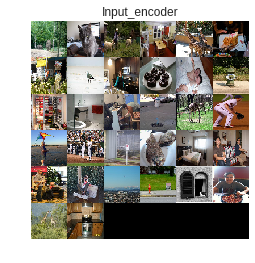

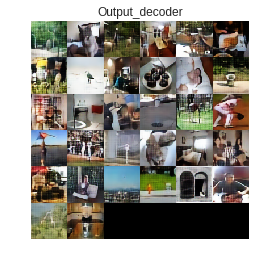

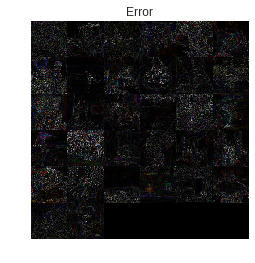

In [0]:
input_encoder,_=validation_sequence[4]
enc=encoder.predict(input_encoder)
dec=decoder.predict(enc)
#print(dec)

def draw(input_show,title="",save_path=None):
  show=np.zeros(((6)*64,(6)*64,3))
  k=0
  for i in range(0,6):
    for j in range(0,6):
      if k < 32 : 
        show[ (64*i):(64*(i+1)),(64*j):(64*(j+1)),...]=input_show[k,...]
      k+=1
  plt.figure()
  plt.imshow(show)
  plt.axis('off')
  plt.title(title)
  if save_path is not None :
    print("saving fig...")
    plt.savefig(save_path)
  
  
draw(input_encoder,title="Input_encoder")#,save_path="output/vvg10_3_input")
draw(dec,title="Output_decoder")#,save_path="output/vvg10_3_output")
draw(abs(input_encoder-dec),title="Error")